In [16]:
#프로젝트를 위한 프로그램을 설치합니다.
import os
import requests
from io import BytesIO
from itertools import product
from datetime import datetime

# 데이터 처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# 분석
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import statsmodels.api as sm
import pmdarima as pm  

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller # 정상성 검정
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings( 'ignore' )

print(pd.__version__)
print(sm.__version__)
print(pm.__version__)

1.2.0
0.12.1
1.8.3


In [17]:
#데이터를 가져와보겠습니다.

file_path_raws = os.getenv('HOME') + '/aiffel/demand_forecasting/data/raws.csv'
df_raws = pd.read_csv(file_path_raws)

df_op_ts = df_raws.set_index('target_dates').sort_index()
df_op_ts.head(10)

,op_rate_0d_all_cars,op_rate_1d_all_cars,op_rate_2d_all_cars,op_rate_3d_all_cars,op_rate_4d_all_cars,op_rate_5d_all_cars,op_rate_6d_all_cars,op_rate_7d_all_cars,op_rate_0d_major_cars,op_rate_1d_major_cars,...,click_d_6,click_d_7,is_clean,avg_precipitation,avg_temperature,month,year,week,weekday,is_weekend
target_dates,,,,,,,,,,,,,,,,,,,,,
2019-09-08,0.381038,0.134719,0.095673,0.081302,0.073248,0.067846,0.059269,0.050881,0.392379,0.130225,...,3850,1190,0,18.8,24.4,9,2019,36,6,True
2019-09-09,0.294693,0.094521,0.058669,0.049279,0.040270,0.033519,0.029069,0.024346,0.316189,0.095190,...,2392,1777,0,90.4,24.7,9,2019,37,0,False
2019-09-10,0.327382,0.115586,0.065420,0.050327,0.043757,0.035807,0.030258,0.026159,0.359647,0.119441,...,2827,2526,0,127.7,24.9,9,2019,37,1,False
2019-09-11,0.382523,0.149016,0.094511,0.073380,0.062836,0.055696,0.048563,0.043774,0.409784,0.142832,...,5867,5083,0,98.4,24.1,9,2019,37,2,False
2019-09-12,0.559916,0.266497,0.201238,0.166553,0.143653,0.130768,0.119568,0.106934,0.568754,0.241148,...,9692,9838,0,38.8,21.3,9,2019,37,3,False
2019-09-13,0.718287,0.399703,0.328298,0.277056,0.239386,0.210855,0.193404,0.178260,0.726530,0.357470,...,6946,7328,0,0.4,22.0,9,2019,37,4,False
2019-09-14,0.589158,0.293503,0.246319,0.210351,0.180779,0.155396,0.138554,0.126423,0.602939,0.266121,...,3980,3004,0,1.7,22.2,9,2019,37,5,True
2019-09-15,0.411680,0.176116,0.136209,0.120233,0.105284,0.088849,0.074827,0.066085,0.422494,0.163079,...,2100,1427,0,4.0,23.4,9,2019,37,6,True
2019-09-16,0.281121,0.090146,0.059408,0.048795,0.042494,0.036145,0.029386,0.024723,0.312250,0.092969,...,2615,1872,0,1.2,22.9,9,2019,38,0,False


In [18]:
#학습데이터와 테스트데이터를 나눕니다.
# 설명 변수 테이블 설정
_x_data = df_raws[['click_d_1', 'click_d_2', 'click_d_3', 'click_d_4', 'click_d_5', 'click_d_6', 'click_d_7', 'is_clean', 'avg_precipitation', 'avg_temperature', 'target_dates']]

_x_weekday = pd.get_dummies(df_raws['weekday'], prefix='weekday', drop_first=False)

_x_data = pd.concat([_x_data, _x_weekday], axis=1)

_x_data.set_index("target_dates", drop=True, inplace=True)
_x_data = _x_data.sort_values('target_dates')

# 예측 대상 데이터 설정
target = df_raws[['op_rate_0d_all_cars', 'target_dates' ]]

target.set_index("target_dates", drop=True, inplace=True)
target = target.sort_values('target_dates')

# Train/Test 데이터셋 나누기
_x_data_train = _x_data[_x_data.index<'2021-04-01']
_x_data_test = _x_data[_x_data.index>='2021-04-01']
target_train = target[target.index<'2021-04-01']
target_test = target[target.index>='2021-04-01']

In [19]:
#나눈 데이터셋을 알맞은 변수에 할당합니다.
x_train = _x_data_train
x_test = _x_data_test
y_train = target_train
y_test = target_test

In [27]:
#grid search를 통해 최적의 파라미터 값을 찾습니다.

def grid_search_sarimax(x_train, y_train):
    # 모수 설정
    p = q = d = P = Q = D = range(2)  # 0부터 1까지 범위를 설정합니다.

    # 초기화
    best_AIC = float("inf")
    best_model = None
    s = 7  # 계절성 주기
    total_iterations = len(p) * len(d) * len(q) * len(P) * len(D) * len(Q)

    # Grid Search 시작
    iter_count = 0
    for param_pdq in product(p, d, q):
        for param_PDS in product(P, D, Q):
            iter_count += 1
            try:
                # SARIMAX 모델 생성 및 학습
                model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=param_pdq, seasonal_order=param_PDS + (s,))
                results = model.fit()
                current_aic = results.aic

                # 최적 AIC 값 업데이트
                if current_aic < best_AIC:
                    best_AIC = current_aic
                    best_model = model

                # 현재 파라미터와 AIC 출력
                print(f"Iter {iter_count}/{total_iterations}: SARIMAX{param_pdq}x{param_PDS} ({s}), AIC = {current_aic}")

            except Exception as e:
                continue  # 모델이 수렴하지 않는 경우나 다른 오류를 무시

    print(f"최적의 SARIMAX 파라미터: {best_model.order}x{best_model.seasonal_order} , AIC:{best_AIC}")
    return best_model.order, best_model.seasonal_order

# 함수 실행
best_order, best_seasonal_order = grid_search_sarimax(x_train, y_train)


#코드에서의 각주
# 해당 코드를 실행하면 엄청난 길이의 SARIMAX값이 나오는데, 중간에 빨간 박스로 에러코드
# 비슷한 코드가 뜹니다. 해당 박스를 없애고 전체 파라미터가 나오는 길이를 간소화시키고 싶어서
# 고민해봤는데, 간소화에 실패한 상태로 올리게 되었습니다. 혹시 회고해주시는 분께서
# 이에 대한 해결방안이나 참고 코드가 있다면..도와주세요...!!!!

Iter 1/64: SARIMAX(0, 0, 0)x(0, 0, 0) (7), AIC = 867.3483846700258
Iter 2/64: SARIMAX(0, 0, 0)x(0, 0, 1) (7), AIC = -2232.0394978926456
Iter 3/64: SARIMAX(0, 0, 0)x(0, 1, 0) (7), AIC = 1000.9463850813165
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20      1     21      1     0     0   2.152D+05  -1.993D+00
  F =  -1.9932696342257263     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99322D+00    |proj g|=  2.10693D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy

   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  

Iter 22/64: SARIMAX(0, 1, 0)x(1, 0, 1) (7), AIC = -2229.2245994491623
ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.09659D+00    |proj g|=  5.77691D+05

At iterate    5    f= -2.09874D+00    |proj g|=  5.53390D+05

At iterate   10    f= -2.09876D+00    |proj g|=  5.50743D+05

At iterate   15    f= -2.09880D+00    |proj g|=  5.46920D+05

At iterate   20    f= -2.09888D+00    |proj g|=  5.42576D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Sk

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Line search cannot locate an adequate poi

Iter 46/64: SARIMAX(1, 0, 1)x(1, 0, 1) (7), AIC = -2366.2483215650855
Iter 47/64: SARIMAX(1, 0, 1)x(1, 1, 0) (7), AIC = -2180.5632596705013
Iter 48/64: SARIMAX(1, 0, 1)x(1, 1, 1) (7), AIC = -2221.5688376700355
Iter 49/64: SARIMAX(1, 1, 0)x(0, 0, 0) (7), AIC = -2219.5638052185295
Iter 50/64: SARIMAX(1, 1, 0)x(0, 0, 1) (7), AIC = -2231.498040106594
Iter 51/64: SARIMAX(1, 1, 0)x(0, 1, 0) (7), AIC = -1924.593821452223
Iter 52/64: SARIMAX(1, 1, 0)x(0, 1, 1) (7), AIC = -2091.9025540923885
   20      2     44      2     0     0   1.106D+05  -1.868D+00
  F =  -1.8679565052546625     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.98769D+00    |proj g|=  1.02694D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of seg

In [29]:
# 모형 구조를 확인합니다.

model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, 
order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))  # 모델 피팅  = 윗 코드에서 나온 BEST SARIMAX
result = model.fit(disp=False)  

# 모델 정보 출력 
print(result.summary())

                                     SARIMAX Results                                     
Dep. Variable:               op_rate_0d_all_cars   No. Observations:                  571
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                1205.124
Date:                           Thu, 31 Aug 2023   AIC                          -2366.248
Time:                                   18:42:05   BIC                          -2270.606
Sample:                               09-08-2019   HQIC                         -2328.934
                                    - 03-31-2021                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
click_d_1          9.342e-06   4.48e-07     20.837      0.000    8.46e-06    1.02e-05
click_d_2         -3.9

In [30]:
# 모델 학습
model = sm.tsa.SARIMAX(endog=y_train, exog=x_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
result = model.fit(disp=False)

# 예측 (학습 데이터 다음부터 지정한 steps만큼)
n = len(y_test)  # 테스트 데이터 길이
forecast = result.get_forecast(steps=n, exog=x_test)  # exog 파라미터로 x_test를 전달
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# RMSE 계산
rmse = np.sqrt(((y_test.values.ravel() - predicted_mean) ** 2).mean())
print(f"RMSE: {rmse}")

RMSE: 0.022641979198986743


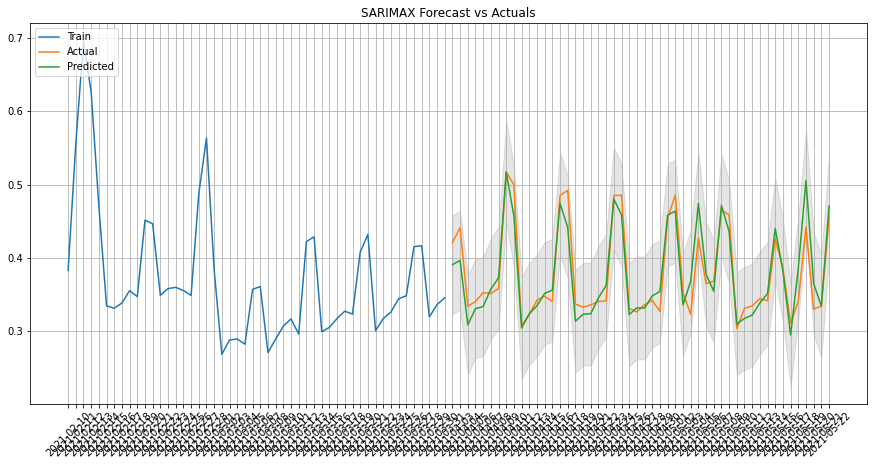

In [32]:
# 시각화 (마지막 50개 데이터만 보여줍니다.)
plt.figure(figsize=(15, 7))
plt.plot(y_train.index[-50:], y_train.values[-50:], label="Train")
plt.plot(y_test.index[-50:], y_test.values[-50:], label="Actual")
plt.plot(y_test.index[-50:], predicted_mean[-50:], label="Predicted")
plt.xticks(rotation=45)
plt.fill_between(y_test.index[-50:], conf_int.iloc[-50:, 0], conf_int.iloc[-50:, 1], color="k", alpha=0.1)
plt.title("SARIMAX Forecast vs Actuals")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## 회고
1. 우선 이번 프로젝트 노드 내용의 개념이 너무 어려웠다... 통계 관련된 전공 개념이 일단 너무 어려웠고, 한 줄 한 줄 그 단어와 의미를 이해하기에 오랜 시간이 걸렸다. 그래서 진도의 절반 정도인 시각화를 목표로 두고 전날 새벽부터 열심히 했는데..ㅠㅠㅠ 결국 챗 GPT의 힘을 빌려 내가 짜놨던 로직에서 조금씩 수정을 거치게 되었다.. 그래도 다른 그루분들께서 통계 전공 내용이나 코드 내용을 자세히 설명해주시거나, 참고 자료를 많이 공유해주셔서, 내 실력에 비해 완성도 있는 수준의 코드를(이 정도 분량이지만) 짤 수 있었다고 생각한다..ㅠㅠ 하지만 그래도 갈 길이 멀어서..열심히 공부해야겠다.

2. 그래프를 통해 시각화하는 부분은 저번 프로젝트부터 계속 눈에 익어왔어서 작성하는데 큰 어려움이 없었지만, 가장 어려웠던 부분은 SARIMA 알고리즘을 완벽하게 이해하고 코드에 적용하는 부분이었다. 그루님이 공유해주신 ARIMA-SARIMA 유튜브 개념영상 덕에 개념 자체는 완벽하게 이해할 수 있었다. 그 부분이 그래도 알고리즘 로직 짜는데 도움이 되었다고 생각한다.

3. 다른 모델은 구현해보지 않아서 비교해 불 순 없었지만, 현재 시각화 한 그래프를 살펴보면, 좌측의 파란 선이 훈련한 선, 우측의 주황 선이 실제 데이터이고 초록색이 예측데이터이다. 이전 ARIMA 노드에서 예측했을 때는 시계열의 특성을 제거하고 결과를 예측해서 예측 정확도가 낮은 모델이 만들어졌던 기억이 난다. 반면 지금 그래프는 그리드서치를 이용해 최적의 파라미터를 찾아서 학습을 시키고, 시계열의 특성을 반영한 SARIMA를 사용해서 예측 정확도가 더 높게 나왔다고 볼 수 있다.